<a href="https://colab.research.google.com/github/edersonjuniorr/ARNN/blob/main/ARNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install librosa numpy scikit-learn pydub tensorflow

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.4046 - loss: 23.6582 - val_accuracy: 0.3846 - val_loss: 8.2941
Epoch 2/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2637 - loss: 28.3913 - val_accuracy: 0.4615 - val_loss: 7.8392
Epoch 3/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3499 - loss: 31.5545 - val_accuracy: 0.4615 - val_loss: 7.3921
Epoch 4/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4126 - loss: 24.3586 - val_accuracy: 0.3077 - val_loss: 8.0378
Epoch 5/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3472 - loss: 22.7583 - val_accuracy: 0.3846 - val_loss: 8.7424
Epoch 6/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4334 - loss: 19.0625 - val_accuracy: 0.3846 - val_loss: 8.8577
Epoch 7/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4700 - loss: 15.8165 - val_accuracy: 0.4615 - val_loss: 8.3669
Epoch 8/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5874 - loss: 15.1733 - val_accuracy: 0.4615 - val_loss: 7.6544
Ep

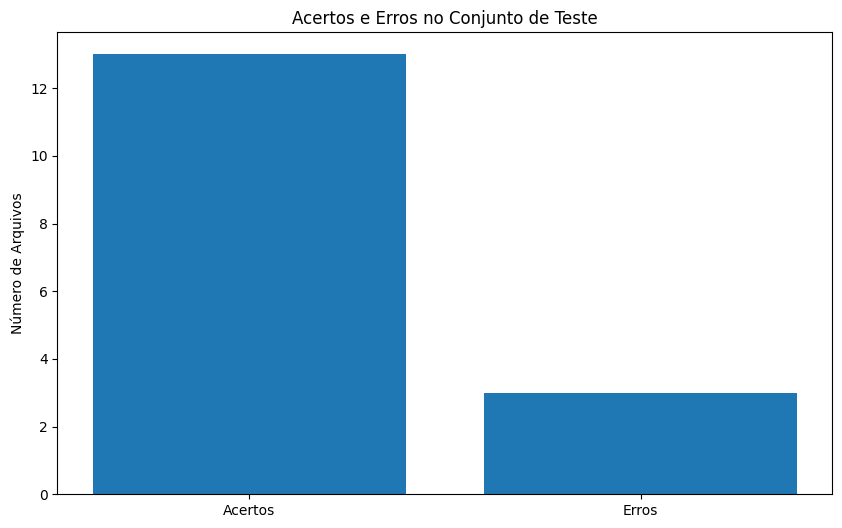


Acertos:
f19.mp3 (Previsto: voz_feminina)
g11.mp3 (Previsto: guitarra)
f11.mp3 (Previsto: voz_feminina)
m5.mp3 (Previsto: voz_masculina)
g4.mp3 (Previsto: guitarra)
g19.mp3 (Previsto: guitarra)
f20.mp3 (Previsto: voz_feminina)
g29.mp3 (Previsto: guitarra)
g6.mp3 (Previsto: guitarra)
f22.mp3 (Previsto: voz_feminina)
m10.mp3 (Previsto: voz_masculina)
g7.mp3 (Previsto: guitarra)
f5.mp3 (Previsto: voz_feminina)

Erros:
m4.mp3 (Verdadeiro: voz_masculina, Previsto: voz_feminina)
m18.mp3 (Verdadeiro: voz_masculina, Previsto: voz_feminina)
m2.mp3 (Verdadeiro: voz_masculina, Previsto: voz_feminina)


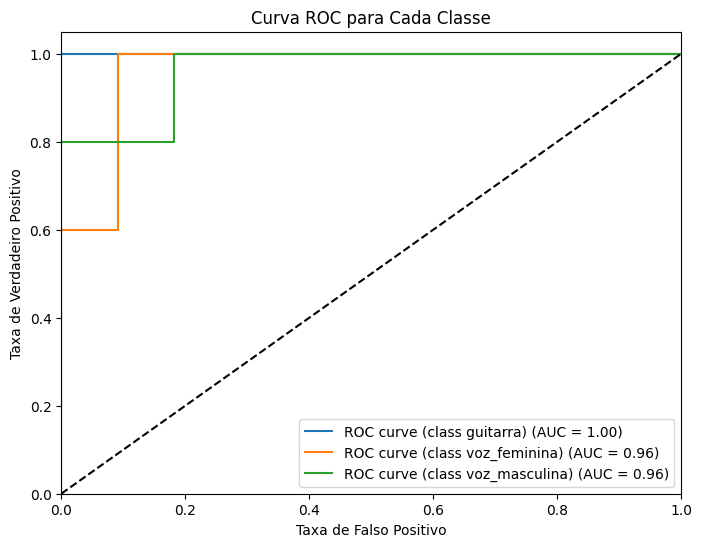

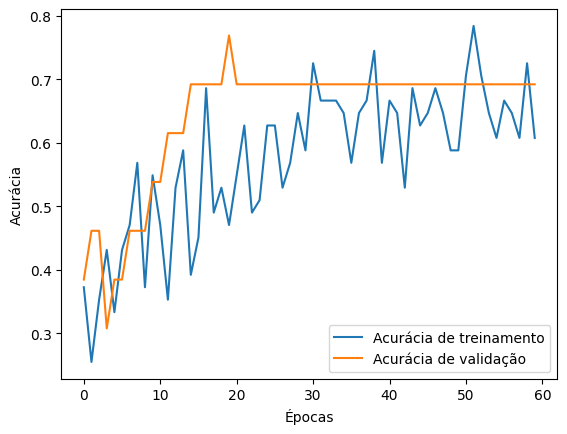

In [23]:
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import os
from pydub import AudioSegment
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, label_binarize
from tensorflow import keras
from tensorflow.keras import layers

def converter_mp3_para_wav(arquivo_mp3, arquivo_wav):
    if not os.path.exists(arquivo_wav):
        sound = AudioSegment.from_mp3(arquivo_mp3)
        sound.export(arquivo_wav, format="wav")

def extrair_mfccs(arquivo_audio):
    y, sr = librosa.load(arquivo_audio, duration=20)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return np.mean(mfccs.T, axis=0)

#Carregar dados, rótulos e nomes de arquivos
def carregar_dados(diretorio, classe_alvo):
    dados = []
    rotulos = []
    nomes_arquivos = []
    for arquivo in os.listdir(diretorio):
        if arquivo.endswith('.mp3'):
            arquivo_mp3 = os.path.join(diretorio, arquivo)
            arquivo_wav = arquivo_mp3.replace('.mp3', '.wav')
            converter_mp3_para_wav(arquivo_mp3, arquivo_wav)
            mfccs = extrair_mfccs(arquivo_wav)
            dados.append(mfccs)
            rotulos.append(classe_alvo)
            nomes_arquivos.append(arquivo)
    return np.array(dados), np.array(rotulos), nomes_arquivos

dados_vf, rotulos_vf, nomes_vf = carregar_dados('data/voz_feminina', 'voz_feminina')
dados_vm, rotulos_vm, nomes_vm = carregar_dados('data/voz_masculina', 'voz_masculina')
dados_g, rotulos_g, nomes_g = carregar_dados('data/guitarra', 'guitarra')

dados_total = np.concatenate((dados_vf, dados_vm, dados_g))
rotulos_total = np.concatenate((rotulos_vf, rotulos_vm, rotulos_g))
nomes_total = np.concatenate((nomes_vf, nomes_vm, nomes_g))

#Codificar rótulos
label_encoder = LabelEncoder()
rotulos_encoded = label_encoder.fit_transform(rotulos_total)
rotulos_bin = label_binarize(rotulos_encoded, classes=np.unique(rotulos_encoded))

#Treino
dados_treino, dados_teste, rotulos_treino, rotulos_teste, nomes_treino, nomes_teste = train_test_split(
    dados_total, rotulos_encoded, nomes_total, test_size=0.2, stratify=rotulos_encoded
)
rotulos_teste_bin = label_binarize(rotulos_teste, classes=np.unique(rotulos_encoded))


#Modelo
modelo = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(40,)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(np.unique(rotulos_encoded)), activation='softmax')
])

modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

historico = modelo.fit(dados_treino, rotulos_treino, epochs=60, validation_split=0.2, verbose=1)

#Previsões
previsoes_probs = modelo.predict(dados_teste)
previsoes = np.argmax(previsoes_probs, axis=1)

#Avaliação
acuracia = accuracy_score(rotulos_teste, previsoes)
print(f'Acurácia: {acuracia}')

# Comparação
acertos = []
erros = []
for i in range(len(rotulos_teste)):
    rotulo_verdadeiro = label_encoder.inverse_transform([rotulos_teste[i]])[0]
    rotulo_previsto = label_encoder.inverse_transform([previsoes[i]])[0]
    if rotulo_verdadeiro == rotulo_previsto:
        acertos.append(f"{nomes_teste[i]} (Previsto: {rotulo_previsto})")
    else:
        erros.append(f"{nomes_teste[i]} (Verdadeiro: {rotulo_verdadeiro}, Previsto: {rotulo_previsto})")

# Criar gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(['Acertos', 'Erros'], [len(acertos), len(erros)])
plt.title('Acertos e Erros no Conjunto de Teste')
plt.ylabel('Número de Arquivos')
plt.show()

# Imprimir detalhes de acertos e erros
print("\nAcertos:")
for acerto in acertos:
    print(acerto)

print("\nErros:")
for erro in erros:
    print(erro)

# Calcular ROC e AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(rotulos_encoded))):
    fpr[i], tpr[i], _ = roc_curve(rotulos_teste_bin[:, i], previsoes_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotar ROC
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(rotulos_encoded))):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {label_encoder.classes_[i]}) (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC para Cada Classe')
plt.legend(loc="lower right")
plt.show()

# Gráfico de histórico de treinamento
plt.plot(historico.history['accuracy'], label='Acurácia de treinamento')
plt.plot(historico.history['val_accuracy'], label='Acurácia de validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()